# KNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from abc import ABC, abstractmethod

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

## Напишем свою реализацию KNN

### Нужные нам метрики

In [2]:
def manhattan(x, y):
    x, y = np.array(x), np.array(y)
    return np.sum(abs(x - y), axis=1)

In [3]:
def euclidean(x, y):
    x, y = np.array(x), np.array(y)
    return np.sum((x - y)**2, axis=1) ** (1/2)

In [4]:
def minkowski(x, y, p=2):
    x, y = np.array(x), np.array(y)
    return np.sum(abs(x - y) ** p, axis=1) ** (1/p)

### Базовый класс

In [5]:
class KNeighbors(ABC):

    def __init__(self,
                 n_neighbors=5,
                 weights='uniform',
                 metric='minkowski',
                 metric_params=None,
                 p=2) -> None:

        self._X = None
        self._y = None

        self._n_neighbors = n_neighbors
        self._weights = weights.lower()
        if self._weights not in ['uniform', 'distance']:
            raise ValueError(f'Unknown value "{weights} for weights param!"')

        if isinstance(metric_params, dict):
            self._metric_params = metric_params
        elif metric_params is None:
            self._metric_params = {}
        else:
            raise TypeError('Unknown param type for metric_params')

        self._distance = None
        if callable(metric):
            self._distance = metric
        elif metric.lower() == 'minkowski':
            self._distance = minkowski
            self._metric_params['p'] = p
        elif metric.lower() == 'manhattan':
            self._distance = manhattan
        elif metric.lower() == 'euclidean':
            self._distance = euclidean
        else:
            raise ValueError(f'Unknown metric {metric} for KNeighbors class!')

    @abstractmethod
    def _predict(self, y, weights):
        return None

    def fit(self, X, y):
        self._X, self._y = np.array(X), np.array(y)
        if self._X.shape[0] != self._y.shape[0]:
            error = 'Found input variables with inconsistent numbers of samples: '  # noqa
            error += f'[{self._X.shape[0]}, {self._y.shape[0]}]'
            raise ValueError(error)

    def predict(self, X):
        return np.apply_along_axis(self._brute_force, 1, np.array(X))

    def _brute_force(self, X):
        distances = self._distance(X, self._X, **self._metric_params)
        prediction = distances.argsort()[:self._n_neighbors]
        weights = self._calc_weights(distances[prediction])
        return self._predict(self._y[prediction], weights)

    def _calc_weights(self, distance):
        if self._weights == 'distance':
            return max(distance) - distance + 0.1

        return np.ones(len(distance))

### KNN для классификации

In [6]:
class KNeighborsClassifier(KNeighbors):

    def _predict(self, y, weights):
        results = []
        predictions = np.unique(y)
        for pred in predictions:
            results.append(sum(weights[y == pred]))

        return predictions[np.array(results).argmax()]

### KNN для регрессии

In [7]:
class KNeighborsRegressor(KNeighbors):

    def _predict(self, y, weights):
        return sum(y * weights) / sum(weights)

## Посмотрим как работает модель

### Загрузка данных

In [8]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

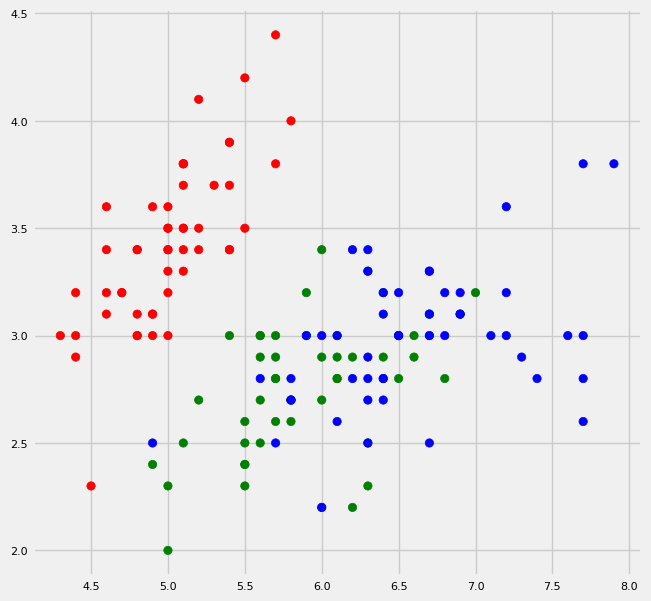

In [9]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
plt.show()

### Работа модели

In [10]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [11]:
history = {
    'k': [],
    'uniform_accuracy': [],
    'distance_accuracy': []
}

for k in range(1, 11, 1):
    history['k'].append(k)

    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    history['uniform_accuracy'].append(accuracy(y_test, y_pred))
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    history['distance_accuracy'].append(accuracy(y_test, y_pred))

In [12]:
history = pd.DataFrame(history)
history.T

,0,1,2,3,4,5,6,7,8,9
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000
uniform_accuracy,0.666667,0.733333,0.766667,0.733333,0.833333,0.866667,0.800000,0.800000,0.866667,0.866667
distance_accuracy,0.666667,0.666667,0.766667,0.733333,0.800000,0.866667,0.833333,0.833333,0.866667,0.866667


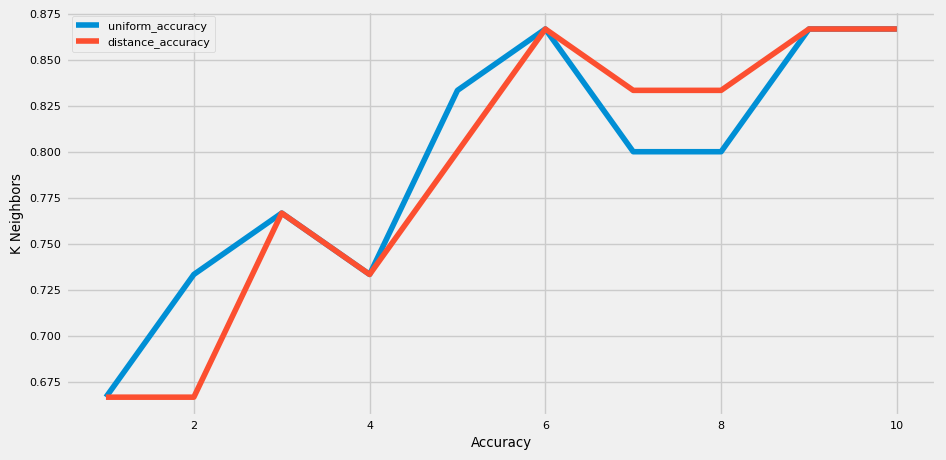

In [13]:
plt.figure(figsize=(10, 5))

plt.plot(history.k, history.uniform_accuracy, label='uniform_accuracy')
plt.plot(history.k, history.distance_accuracy, label='distance_accuracy')

plt.xlabel('Accuracy')
plt.ylabel('K Neighbors')

plt.legend()
plt.grid(True)

plt.show()

Алгоритм показал лучшую точность при к = 6

In [14]:
def plot_graph(model, X, y):
    cmap = ListedColormap(['red', 'green', 'blue'])
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .05

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    z = np.array(z).reshape(xx.shape)

    plt.pcolormesh(xx, yy, z, cmap=cmap_light, shading='auto')

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

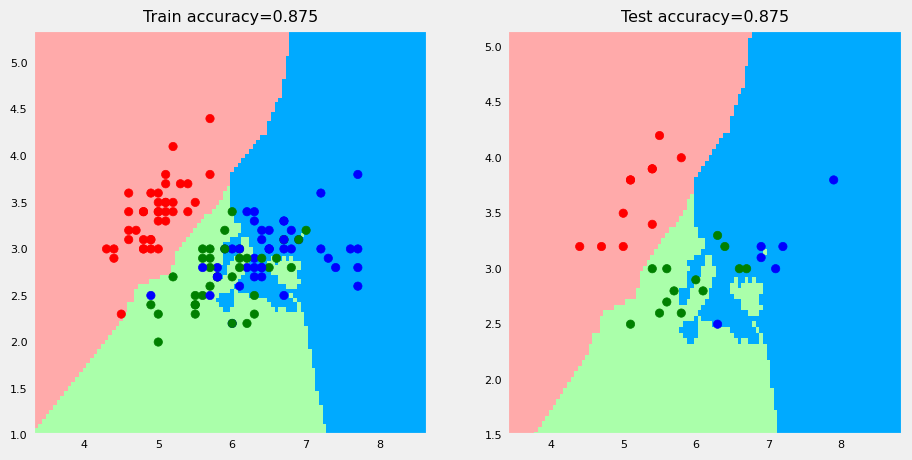

In [15]:
knn = KNeighborsClassifier(n_neighbors=6, weights='distance')
knn.fit(X_train, y_train)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
acc = accuracy(y_train, knn.predict(X_train))
plt.title(f'Train accuracy={acc}')
plot_graph(knn, X_train, y_train)


plt.subplot(1, 2, 2)
acc = accuracy(y_train, knn.predict(X_train))
plt.title(f'Test accuracy={acc}')
plot_graph(knn, X_test, y_test)

plt.show()